# Modeling task-induced activity in a neural network accounting for network connectivity


Set up environment

In [1]:
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
import seaborn as sns
sns.set_style("white")
import statsmodels.formula.api as smf

Import custom modules

In [2]:
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'helpers')))
from eGLM_model import default_args, generateStructuralNetwork, generateSynapticNetwork, networkModel
from eGLM_helpers import phi, run_ucr_glm, run_ext_glm, make_stimtimes, sim_network_task_glm,  get_true_baseline, plot_sim_network_glm

Importing eGLM helpers...
All eGLM helpers imported!


In [3]:
sim_args = copy(default_args)


## Neural network model

In this notebook we expand on simulations described in [Ito et al. (2017)](https://www.nature.com/articles/s41467-017-01000-w.pdf) and [Cole et al. (2016)](https://www.nature.com/articles/nn.4406.pdf). Ito et al. propose a dynamic neural network model to simulate resting state and task data. Accordingly change in activity in each node is a function of the local connectivity determined by $s$, global connectivity determined by $g$ and task activity for that node described in $I$

\begin{equation*}
\frac{dx_i}{dt}\tau_i = -x_i(t) + s\phi\big(x_i(t)\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + I_i(t)
\end{equation*}

where transformation function $\phi$ is
\begin{equation*}
\phi(x) = \tanh(x) = \frac{\sinh(x)}{\cosh(x)} = \frac{e^{2x}-1}{e^{2x}+1}
\end{equation*}

This transformation is intended to introduce *"a nonlinearity to the interactions among units that is
similar to aggregate nonlinearity from neuronal action potentials"* as explained in [Cole et al. (2016)](https://www.nature.com/articles/nn.4406.pdf). The transformation is a sigmoid that bounds the activity it is applied to beween 0 and 1.

Given the data-generating process above the time-shifted network activity can be written as:

\begin{equation*}
x_i(t+1) = \frac{dx_i}{dt}\tau_i + x_i(t)
\end{equation*}

If we are interested in capturing the effect of the activity "induced" by the task, we can capture this by inverting the linear model below:

\begin{equation*}
x_i(t+1) = s\phi\big(x_i(t)\big) + g\Bigg(\sum_{j\neq i}^{N} W_{ij}\phi\big(x_j(t)\big)\Bigg) + I_i(t)
\end{equation*}

Unlike the traditional GLM framework used in fMRI analyses this extended GLM contains additional regressors to account for the node's own activity (recurrence) and the network activity (functional connectivity). 


## Baseline simulation

Using this data generating framework first we simulate a topdown task that stimulates nodes only in the hub network. No noise is added to this simulation. It is intended to serve as a baseline to compare the changes for all the tests below. 

The plot below will serve as a template for several tests later in this notebook.
The x-axis denotes each node and the y-axis the regression coefficient of task activity for each nodes' time series. The blue line shows the parameters using the classic GLM framework (cGLM) and the yellow line are the parameter estimates when the time series is corrected for its connectivity with the rest of the network using the extended GLM equation above (eGLM). The vertical lines denote community boundaries. In the baseline simulation there is one hub network and two local networks. The horizontal line depicts the "true" magnitude of the task parameter accounting for that nodes connectivity and stimulation status (detailed below).

In [4]:
sim_args.update({'stimsize': 10})
sim_args

{'bottomup': False,
 'dt': 1,
 'ea': 100,
 'g': 1,
 'hubnetwork_dsity': 0.25,
 'I': None,
 'innetwork_dsity': 0.6,
 'iv': 200,
 'local_com': 1,
 'ncommunities': 3,
 'noise': None,
 'noise_loc': 0,
 'noise_scale': 0,
 'nodespercommunity': 35,
 'outnetwork_dsity': 0.08,
 'plot_network': False,
 'plot_task': False,
 's': 1,
 'sa': 50,
 'showplot': False,
 'standardize': False,
 'stim_mag': 0.5,
 'stimsize': 10,
 'taskdata': None,
 'tasktiming': None,
 'tau': 1,
 'Tmax': 1000,
 'topdown': True,
 'W': None}

In [5]:
base_sim = sim_network_task_glm(args_dict=sim_args)

Text(85, 1.75, 'Local 2')

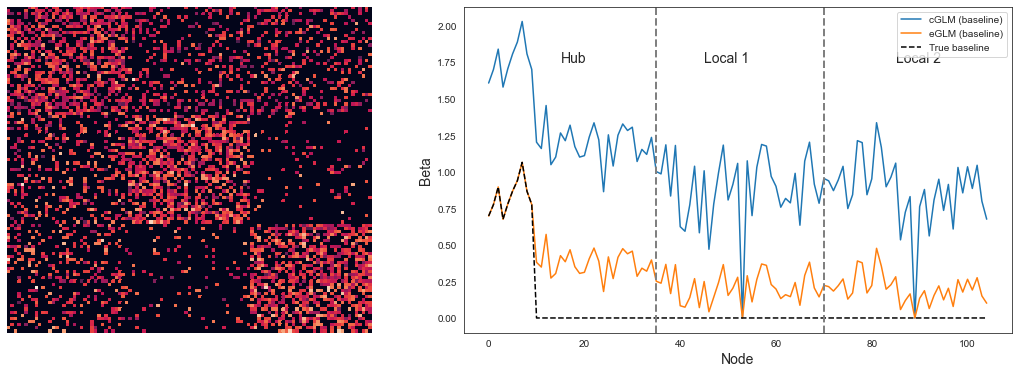

In [6]:
plt.rcParams["figure.figsize"][0] = 18
plt.rcParams["figure.figsize"][1] = 6
fig,a =  plt.subplots(1,2, gridspec_kw={'width_ratios': [.8, 1.2]})
sns.heatmap(base_sim['W'], xticklabels=False, yticklabels=False, cbar=False, ax = a[0])
plot_sim_network_glm(sim = base_sim, base_label = "True baseline", ax=a[1])
a[1].text(x = 15, y = 1.75, s = "Hub", fontsize = 14)
a[1].text(x = 45, y = 1.75, s = "Local 1", fontsize = 14)
a[1].text(x = 85, y = 1.75, s = "Local 2", fontsize = 14)

With the change in the GLM equation the task parameter estimates can change in two ways:

- bias: the relationship between the timeseries and task regressor can become stronger or weaker on average
- variance: the relationship between the timeseries and the task regressor can vary more or less across nodes. 

The plot above suggests that when the activity of each node changes only as a function of recurrence, network activity and task stimulation without any additional random noise the eGLM estimates of the relationship between node activity and task regressor are less biased and less variable.

## Connectivity level and overestimation

Text(0.07, 0.5, 'r = 0.404')

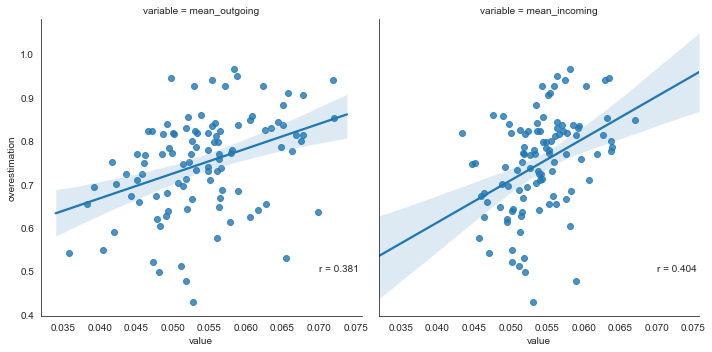

In [7]:
mean_outgoing = np.mean(base_sim['W'], axis = 0) #col means
mean_incoming = np.mean(base_sim['W'], axis = 1) #row means
overestimation = base_sim['ucr_betas'] - base_sim['ext_betas']

rem_ind = np.array(np.where(overestimation==0)).flatten()
mean_outgoing = np.delete(mean_outgoing, rem_ind)
mean_incoming = np.delete(mean_incoming, rem_ind)
overestimation = np.delete(overestimation, rem_ind)

df = pd.DataFrame(data  = {'mean_outgoing': mean_outgoing, 'mean_incoming': mean_incoming, 'overestimation': overestimation})
df = pd.melt(df, id_vars=['overestimation'], value_vars = ['mean_outgoing', 'mean_incoming'])

g = sns.lmplot(x="value", y="overestimation", col="variable", data=df)
g.axes[0][0].text(0.07, .5, 'r = '+str(round(np.corrcoef(mean_outgoing, overestimation)[0, 1], 3)))
g.axes[0][1].text(0.07, .5, 'r = '+str(round(np.corrcoef(mean_incoming, overestimation)[0, 1], 3)))

## Different noise levels

First we examine the effect of different amounts of noise. The change in activity in the generative model above is described as a function of recurrence, network activity and task stimulation. Task stimulation can, however, be incorporated in a noisy manner. That is, the task induced activity at each time point is a function of the true task stimulation $I_i(t)^*$ plus some random error $\epsilon$

\begin{equation*}
I_i(t) = I_i(t)^* + \epsilon
\end{equation*}

where 

\begin{equation*}
\epsilon \sim \mathcal{N}(\mu,\,\sigma^{2})\
\end{equation*}

In the "noiseless" baseline simulation above $\mu$ and $\sigma$ were set to 0.  When the noise parameter is turned on a random number from a normal distribution with a mean of 0 and specified standard deviation is added to the activity level at each time point. The amount of noise is changed by modifying the variance of this distribution and leaving the mean at 0. 

Below we plot time series for a stimulated and non-stimulated node for varying levels of noise. The time series without noise points out the amplification of the task signal through connections to the rest of the network. This is why the activity for a non-stimulated node (right plot) is not at 0 for the whole task either. Importantly, this suggests that the "correct" baseline that the task activity parameter estimates should be compared to is not the stimulus timing for each node but the remaining relationship between the time series and task timing once the amplification through the rest of the network is accounted for.

In [8]:
td_tasktiming, td_stimtimes = make_stimtimes(stim_nodes=base_sim['stim_nodes'], args_dict = sim_args)

In [9]:
noise_ts = {}

noise_sds = [0, .5, 1, 2, 5]

In [10]:
tmp_args_dict = copy(sim_args)
tmp_args_dict.update({'W': base_sim['W'], 'noise':1})
for noise_sd in noise_sds:
    var_name = "noise_"+str(noise_sd)
    tmp_args_dict.update({'noise_scale': noise_sd})
    noise_ts[var_name] = sim_network_task_glm(args_dict = tmp_args_dict)

Text(0.5, 1.0, 'Non-stimulated node')

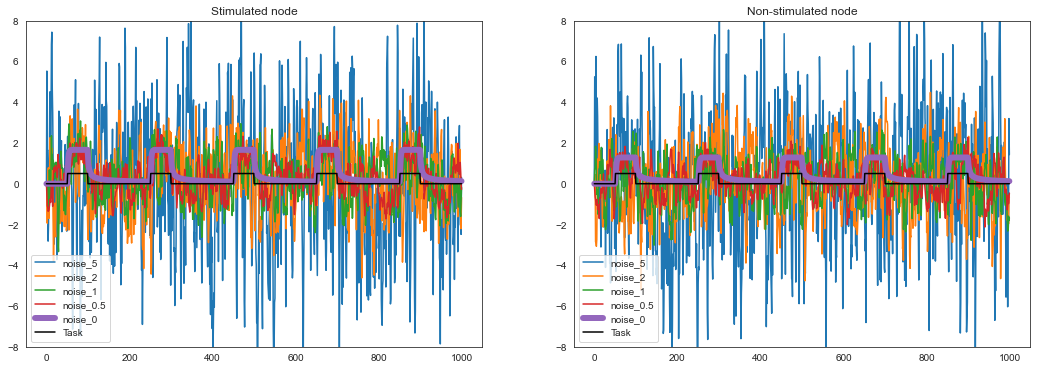

In [11]:
plt.rcParams["figure.figsize"][0] = 18
plt.rcParams["figure.figsize"][1] = 6

#Plot same stimulated node's timeseries with and without noise
fig,a =  plt.subplots(1,2)
curns = [0, 21]
rkeys = list(noise_ts.keys())
rkeys.reverse()
for i in range(2):
    curn = curns[i]
    for j in rkeys:
        if j == 'noise_0':
            a[i].plot(range(noise_ts[j]['taskdata'].shape[1]), noise_ts[j]['taskdata'][curn,:], linewidth = 6,label=j)
        else:
            a[i].plot(range(noise_ts[j]['taskdata'].shape[1]), noise_ts[j]['taskdata'][curn,:],label=j)
    a[i].plot(range(noise_ts[j]['taskdata'].shape[1]), td_stimtimes[0], label="Task", color="black")
    a[i].legend(loc="best")
    a[i].set_ylim([-8,8])
    
a[0].set_title("Stimulated node")
a[1].set_title("Non-stimulated node")

The effect of adding noise to the timeseries has different effects on the task parameter estimates using the two approaches.  

For the classic GLM:
- without noise the task regressors capture the relationship between task timing and the activity level that is amplified by recurring connections in the network.
- with noise the overestimation of the task regressor that reflects the amplification is reduced because the systematic relationship between the task regressor and the node's activity is destroyed by noise. The parameter estimates reduce with increasing noise (both for stimulated and non-stimulad nodes). The larger the noise the more the estimates look spuriously like the "true" values.

For the extended GLM
- without noise the task regressors capture the relationship between the timeseries and the task regressor accouting for recurrence and network activity. This functions as the baseline to compare the recovered parameters for all other noise levels.
- with noise the corrected parameter estimates are again lower than the noiseless estimates but now unlike the classic GLM where they looked spuriously similar to the true value they underestimated the real relationship between stimulated nodes and task activity.

**What would be an appropriate level of noise for empirical data?**



In [12]:
values = ["C"+str(x) for x in range(len(noise_ts.keys()))]
col_lookup = dict(zip(rkeys, values))

Text(0.5, 1.0, 'Extended GLM')

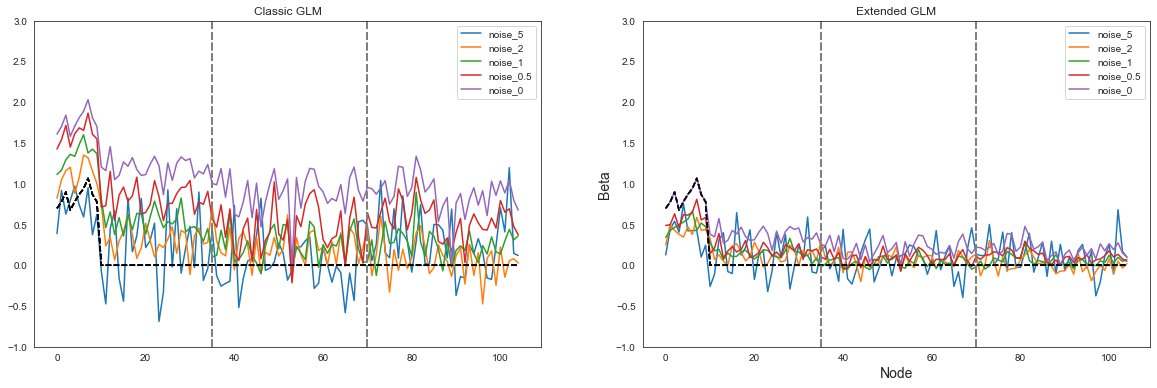

In [13]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 6
fig, a =  plt.subplots(1,2)

baseline_vec = get_true_baseline(noise_ts['noise_0'])

beta_keys = ['ucr_betas', 'ext_betas']
for i, bk in enumerate(beta_keys):
    for j in rkeys:
        a[i].plot(noise_ts[j][bk], label = j, color = col_lookup[j])

        a[i].plot(baseline_vec, 
                  color = "black", linestyle = '--')
    
        for n in range(1,3):
            a[i].axvline(x=35*n,linewidth=2, color='gray', ls = "--")
        a[i].legend(loc="best")
        a[i].set_ylim([-1,3])
        
plt.ylabel('Beta',fontsize=14)
plt.xlabel('Node',fontsize=14)
a[0].set_title("Classic GLM")
a[1].set_title("Extended GLM")
#fig.suptitle('Standardized parameters')

## Different network structures


### Changing network density

#### Innetwork density

The innetwork density controls the probability of a given node to be connected to another node within the same community. In a topdown task (where only the hub network is stimulated) increasing the innetwork density exacerbates the bleeding of true activity from the stimulated nodes onto non-stimulated nodes in the same network.

In [14]:
new_sim1_args = copy(sim_args)
new_sim1_args.update({'innetwork_dsity': .85})

new_sim1 = sim_network_task_glm(args_dict=new_sim1_args)

new_sim2_args = copy(sim_args)
new_sim2_args.update({'innetwork_dsity': .15})

new_sim2 = sim_network_task_glm(args_dict=new_sim2_args)

Text(0.5, 1.0, 'Difference')

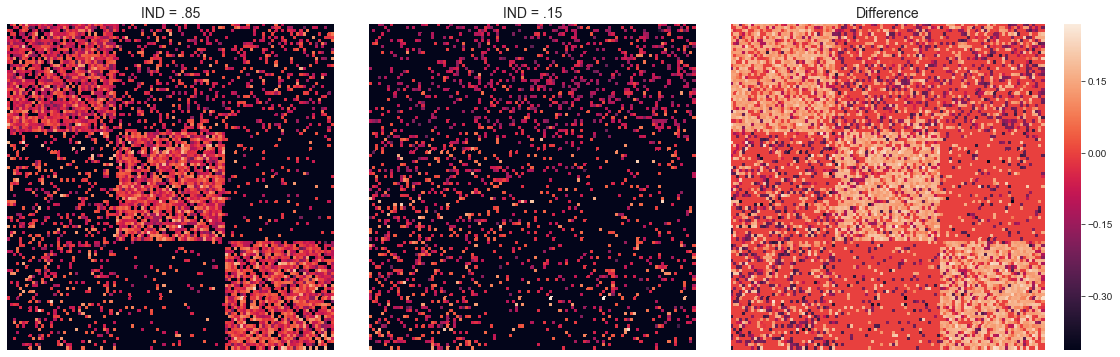

In [15]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 6

fig, ax = plt.subplots(1,3, gridspec_kw={'width_ratios': [1, 1, 1.2]})

sns.heatmap(new_sim1['W'], xticklabels=False, yticklabels=False, ax = ax[0], cbar=False)
sns.heatmap(new_sim2['W'], xticklabels=False, yticklabels=False,ax = ax[1], cbar=False)
sns.heatmap(new_sim1['W']-new_sim2['W'], xticklabels=False, yticklabels=False,ax = ax[2])

plt.subplots_adjust(wspace=0.1)

ax[0].set_title("IND = .85", size = 14)
ax[1].set_title("IND = .15", size = 14)
ax[2].set_title("Difference", size = 14)

Text(0, 0.5, '')

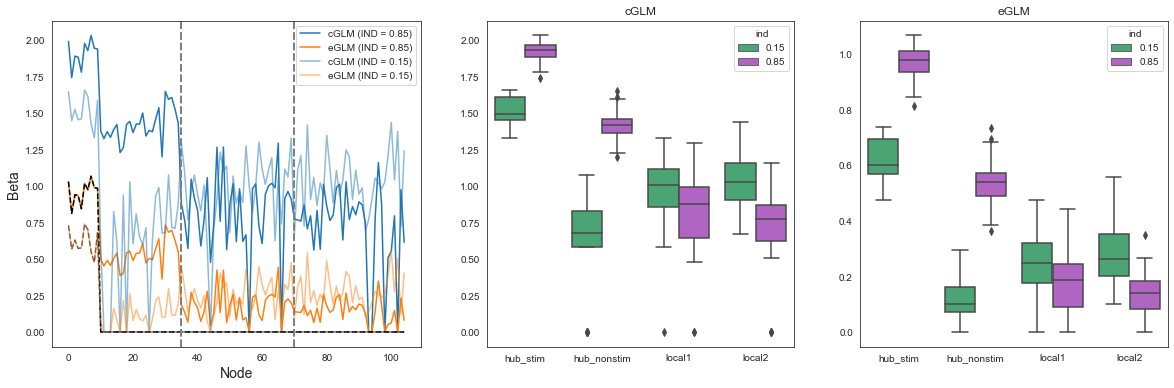

In [16]:
fig, a = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1.2, 1, 1]})
plt.rcParams["figure.figsize"][0] = 22

plot_sim_network_glm(new_sim1, ucr_label="cGLM (IND = 0.85)", ext_label="eGLM (IND = 0.85)", ax=a[0])
plot_sim_network_glm(new_sim2, alp = .5, ucr_label="cGLM (IND = 0.15)", ext_label="eGLM (IND = 0.15)", ax=a[0])

df = pd.DataFrame(data = {'node': range(new_sim1['ncommunities']*new_sim1['nodespercommunity']),
                         'community': new_sim1['stimsize']*['hub_stim'] + (new_sim1['nodespercommunity']-new_sim1['stimsize'])*['hub_nonstim'] + new_sim1['nodespercommunity']*['local1'] + new_sim1['nodespercommunity']*['local2'],
                         'cGLM_beta': new_sim1['ucr_betas'],'eGLM_beta': new_sim1['ext_betas'], 'ind':new_sim1['innetwork_dsity']})

df2 = pd.DataFrame(data = {'node': range(new_sim1['ncommunities']*new_sim1['nodespercommunity']),
                         'community': new_sim1['stimsize']*['hub_stim'] + (new_sim1['nodespercommunity']-new_sim1['stimsize'])*['hub_nonstim'] + new_sim1['nodespercommunity']*['local1'] + new_sim1['nodespercommunity']*['local2'],
                         'cGLM_beta': new_sim2['ucr_betas'],'eGLM_beta': new_sim2['ext_betas'], 'ind':new_sim2['innetwork_dsity']})

df = df.append(df2)
df = pd.melt(df, value_vars = ["cGLM_beta", "eGLM_beta"], id_vars = ["node", "community", "ind"])
df2 = df.query("variable == 'eGLM_beta' ")
df = df.query("variable == 'cGLM_beta' ")

sns.boxplot(x = "community", y = "value", hue = "ind", data = df, palette = ["mediumseagreen", "mediumorchid"], ax = a[1])
sns.boxplot(x = "community", y = "value", hue = "ind", data = df2, palette = ["mediumseagreen", "mediumorchid"], ax = a[2])
a[1].set_title("cGLM")
a[2].set_title("eGLM")
a[1].set_xlabel("")
a[1].set_ylabel("")
a[2].set_xlabel("")
a[2].set_ylabel("")

#### Outnetwork density

The outnetwork density controls the probability of **local networks** having outside connections with **other local communities**. Since this is a topdown task increasing the outnetwork density doesn't have an effect on neither the classic nor eGLM estimates.

In [17]:
new_sim_args = copy(sim_args)
new_sim_args.update({'outnetwork_dsity': .95})

new_sim = sim_network_task_glm(args_dict=new_sim_args)

Text(0.5, 1.0, 'Difference')

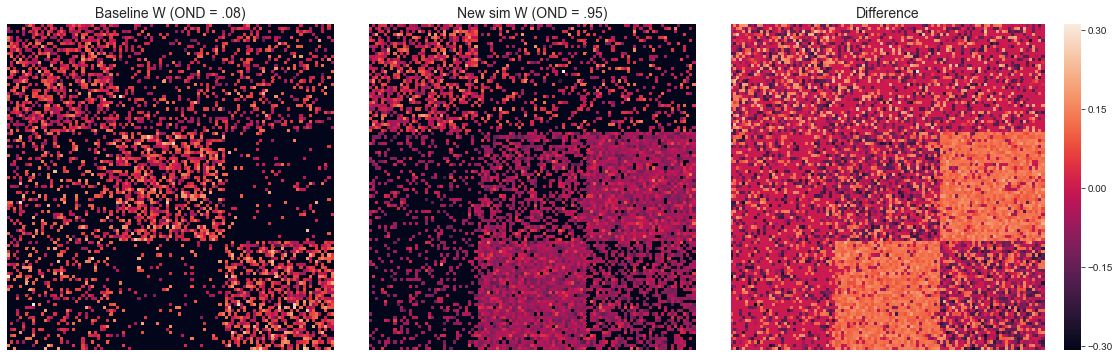

In [18]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 6

fig, ax = plt.subplots(1,3, gridspec_kw={'width_ratios': [1, 1, 1.2]})

sns.heatmap(base_sim['W'], xticklabels=False, yticklabels=False, ax = ax[0], cbar=False)
sns.heatmap(new_sim['W'], xticklabels=False, yticklabels=False,ax = ax[1], cbar=False)
sns.heatmap(new_sim['W']-base_sim['W'], xticklabels=False, yticklabels=False,ax = ax[2])

plt.subplots_adjust(wspace=0.1)

ax[0].set_title("Baseline W (OND = .08)", size = 14)
ax[1].set_title("New sim W (OND = .95)", size = 14)
ax[2].set_title("Difference", size = 14)

Text(0, 0.5, '')

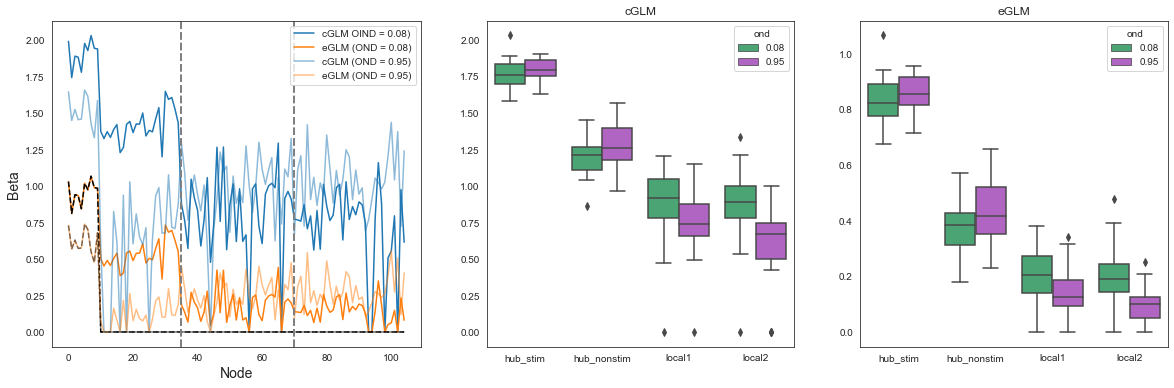

In [19]:
fig, a = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1.2, 1, 1]})
plt.rcParams["figure.figsize"][0] = 22

plot_sim_network_glm(base_sim, ucr_label="cGLM OND = 0.08)", ext_label="eGLM (OND = 0.08)", ax=a[0])
plot_sim_network_glm(new_sim, alp = .5, ucr_label="cGLM (OND = 0.95)", ext_label="eGLM (OND = 0.95)", ax=a[0])

df = pd.DataFrame(data = {'node': range(base_sim['ncommunities']*base_sim['nodespercommunity']),
                         'community': base_sim['stimsize']*['hub_stim'] + (base_sim['nodespercommunity']-base_sim['stimsize'])*['hub_nonstim'] + base_sim['nodespercommunity']*['local1'] + base_sim['nodespercommunity']*['local2'],
                         'cGLM_beta': base_sim['ucr_betas'],'eGLM_beta': base_sim['ext_betas'], 'ond':base_sim['outnetwork_dsity']})

df2 = pd.DataFrame(data = {'node': range(new_sim['ncommunities']*new_sim['nodespercommunity']),
                         'community': new_sim['stimsize']*['hub_stim'] + (new_sim['nodespercommunity']-new_sim['stimsize'])*['hub_nonstim'] + new_sim['nodespercommunity']*['local1'] + new_sim['nodespercommunity']*['local2'],
                         'cGLM_beta': new_sim['ucr_betas'],'eGLM_beta': new_sim['ext_betas'], 'ond':new_sim['outnetwork_dsity']})

df = df.append(df2)
df = pd.melt(df, value_vars = ["cGLM_beta", "eGLM_beta"], id_vars = ["node", "community", "ond"])
df2 = df.query("variable == 'eGLM_beta' ")
df = df.query("variable == 'cGLM_beta' ")

sns.boxplot(x = "community", y = "value", hue = "ond", data = df, palette = ["mediumseagreen", "mediumorchid"], ax = a[1])
sns.boxplot(x = "community", y = "value", hue = "ond", data = df2, palette = ["mediumseagreen", "mediumorchid"], ax = a[2])
a[1].set_title("cGLM")
a[2].set_title("eGLM")
a[1].set_xlabel("")
a[1].set_ylabel("")
a[2].set_xlabel("")
a[2].set_ylabel("")


#### Hub network density

The hub network density controls the probability of a hub node to be connected to other local networks. Increasing it impacts the classic GLM estimates in the local networks by increasing the leakage from the hub network.

### Changing information transfer strength (ITS)

The information transfer strength control the degree to which activity incoming from a connected node affects the change in the activity of a given node. One parameter ($g$) controls the degree of change for activity coming from the rest of the network to the node while another ($s$) control the weight of current node's activity for the next time step.

#### Change in time series

#### Change in parameter estimates

### Changing temporal resolution

#### Increasing $dt$

#### Decreasing $dt$

## Different task structures

The initial task was a top down task that stimulated nodes only in the hub network and trickled activity down to the other nodes.

Other task activations are possible.

Things to modulate:  
- Number of nodes stimulated
- Stimulating only local community
- Stimulating both hub and local community
- Magnitude of stimulation (different from 0.5)

### Changing number of stimulated nodes


### Stimulating only local community

### Stimulating both hub and local community



### Changing magnitude of stimulation

<a id='summary'></a>
## Summary